In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

from sklearn.cluster import KMeans

import copy

from imblearn.over_sampling import SMOTE


%matplotlib inline

In [ ]:
engg = pd.read_csv('/content/collegePlace.csv')
engg

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1
3,21,Male,Information Technology,0,8,0,1,1
4,22,Male,Mechanical,0,8,1,0,1
...,...,...,...,...,...,...,...,...
2961,23,Male,Information Technology,0,7,0,0,0
2962,23,Male,Mechanical,1,7,1,0,0
2963,22,Male,Information Technology,1,7,0,0,0
2964,22,Male,Computer Science,1,7,0,0,0


In [ ]:
engg.describe()

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
count,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000
mean,21.485840,0.703641,7.073837,0.269049,0.192178,0.552596
std,1.324933,0.740197,0.967748,0.443540,0.394079,0.497310
min,19.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,21.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,22.000000,1.000000,8.000000,1.000000,0.000000,1.000000
max,30.000000,3.000000,9.000000,1.000000,1.000000,1.000000


In [ ]:
engg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                2966 non-null   int64 
 1   Gender             2966 non-null   object
 2   Stream             2966 non-null   object
 3   Internships        2966 non-null   int64 
 4   CGPA               2966 non-null   int64 
 5   Hostel             2966 non-null   int64 
 6   HistoryOfBacklogs  2966 non-null   int64 
 7   PlacedOrNot        2966 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 185.5+ KB


In [ ]:
engg.isna().sum()

Age                  0
Gender               0
Stream               0
Internships          0
CGPA                 0
Hostel               0
HistoryOfBacklogs    0
PlacedOrNot          0
dtype: int64

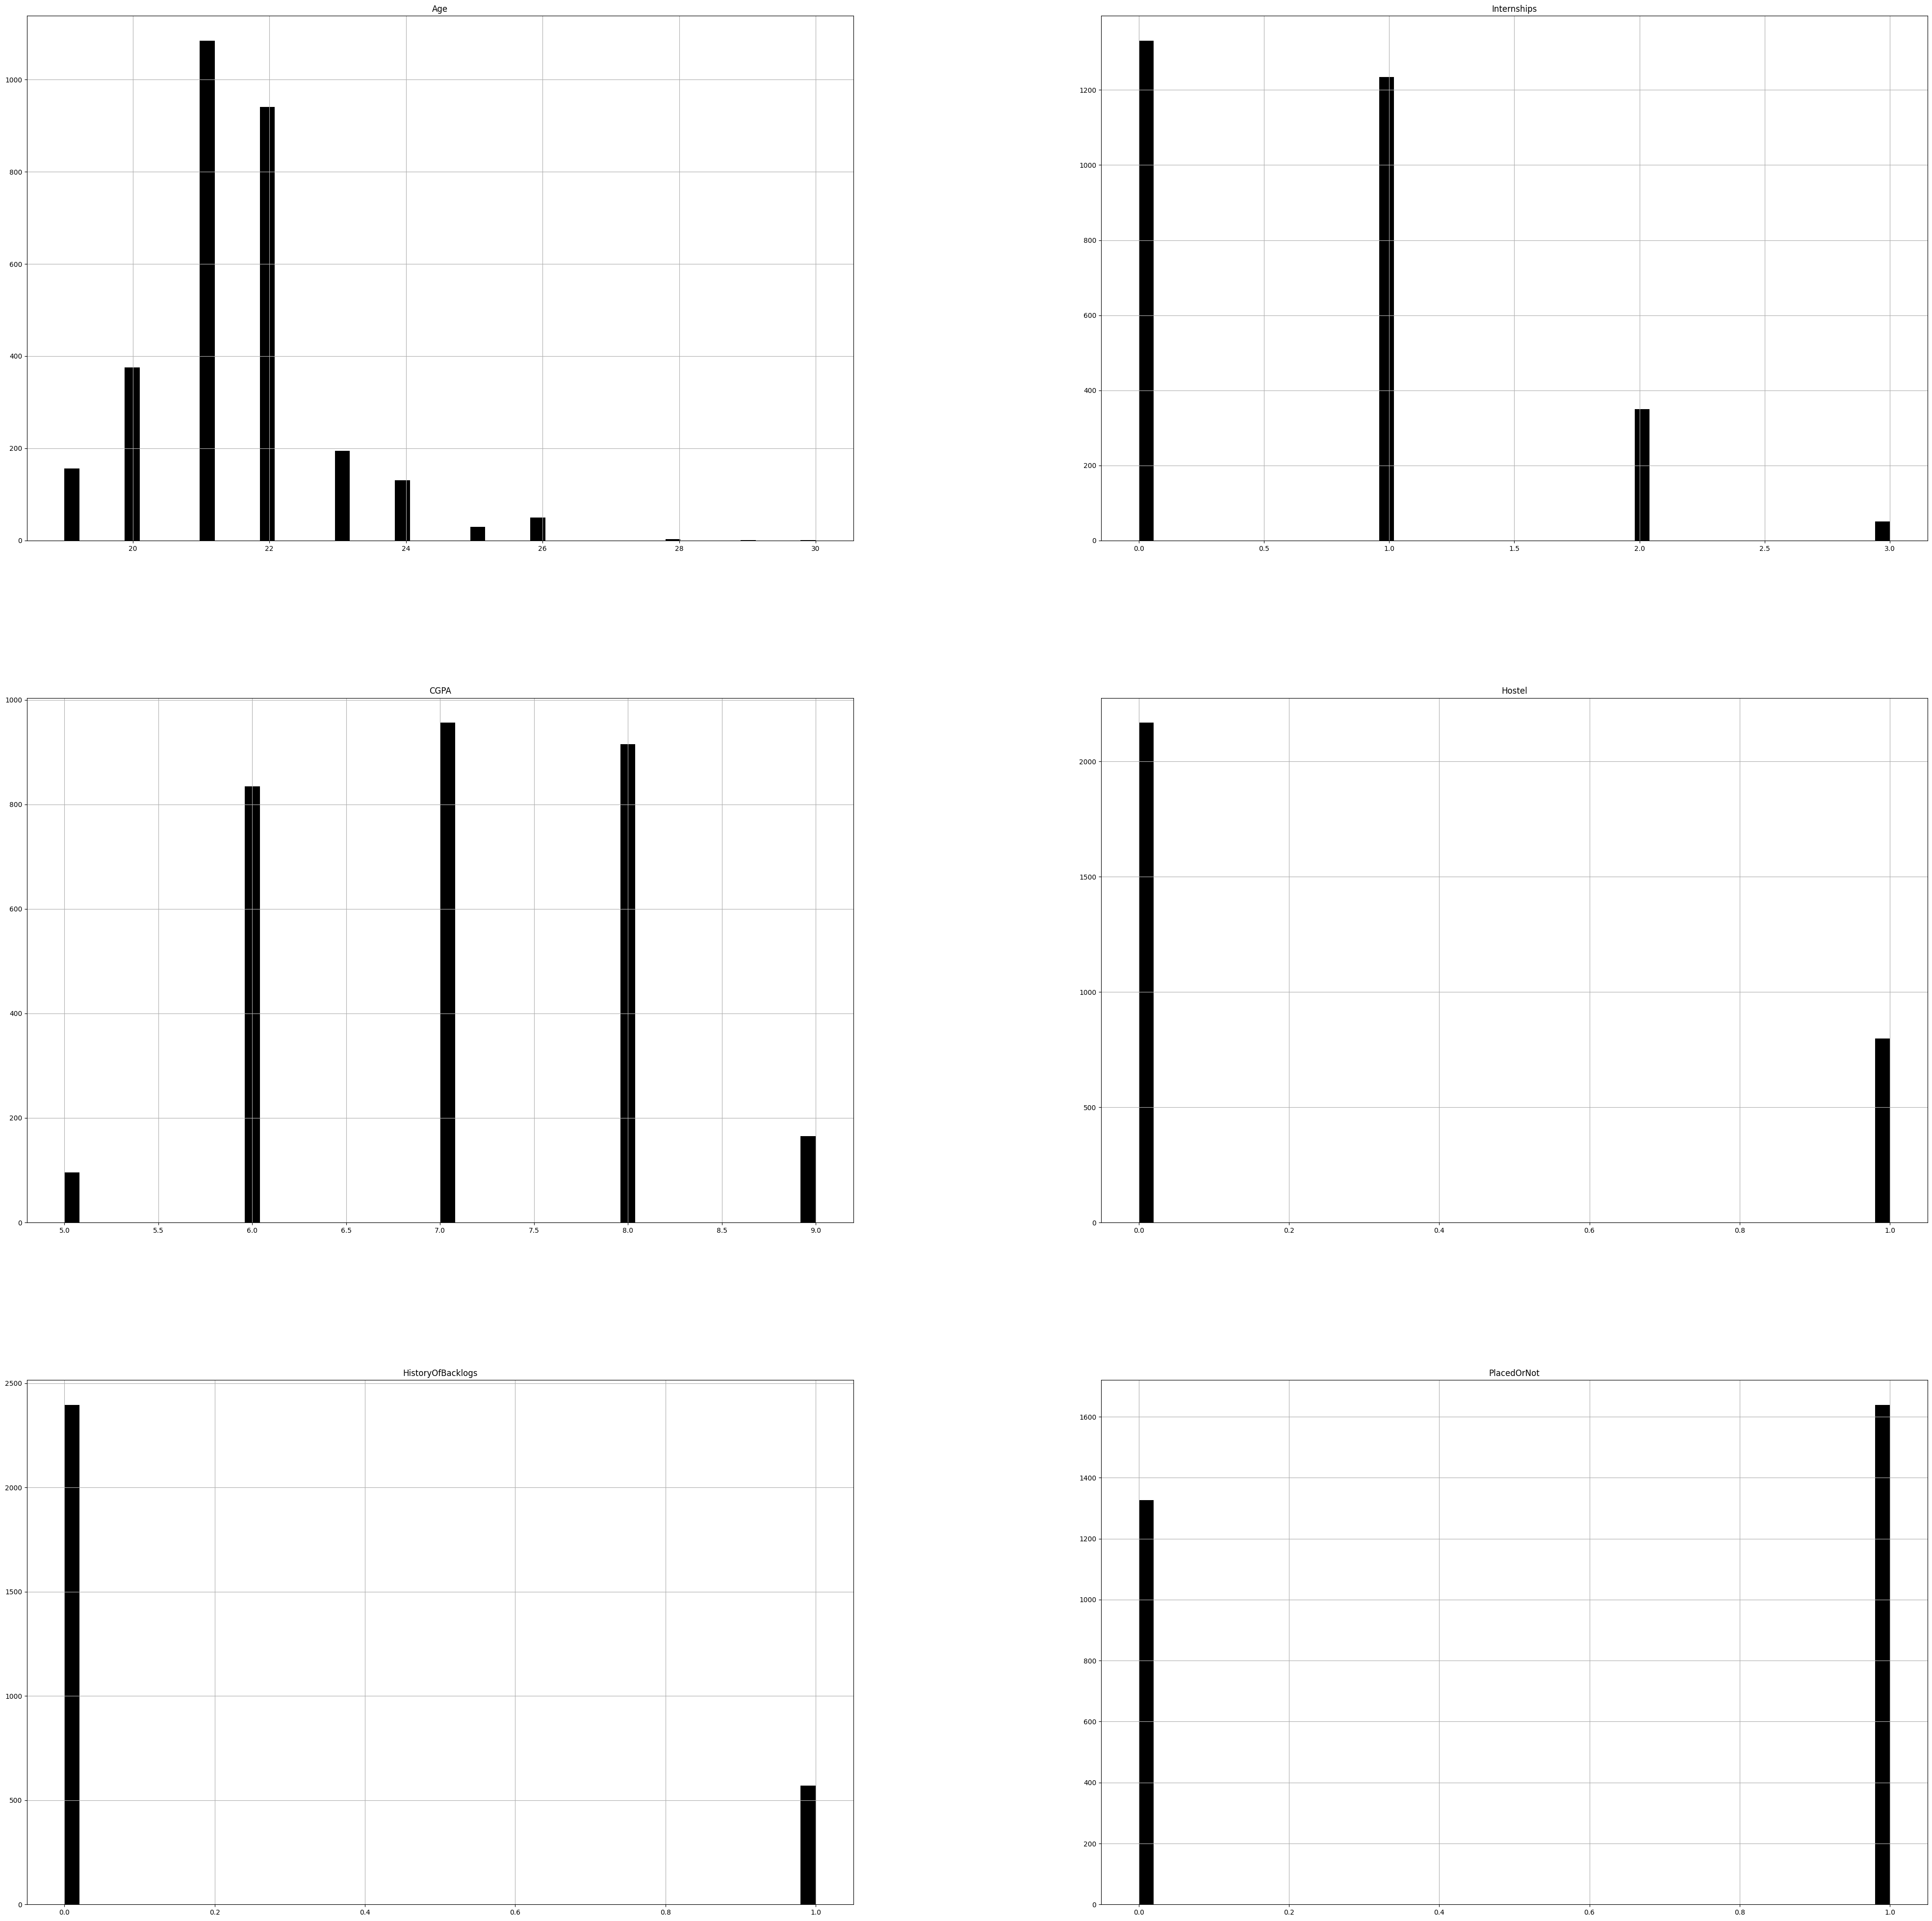

In [ ]:
engg.hist(figsize=(50,50), bins=50, color="black");

<Axes: >

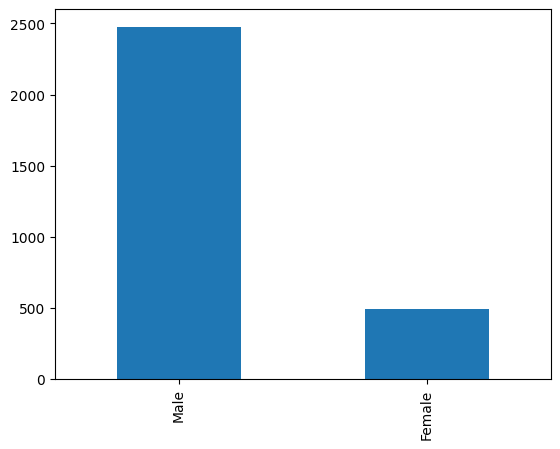

In [ ]:
engg['Gender'].value_counts().plot(kind='bar')

<Axes: >

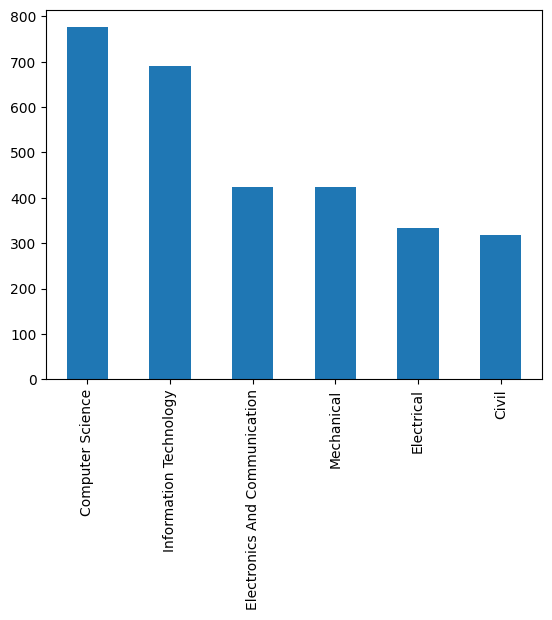

In [ ]:
engg['Stream'].value_counts().plot(kind='bar')

<Axes: >

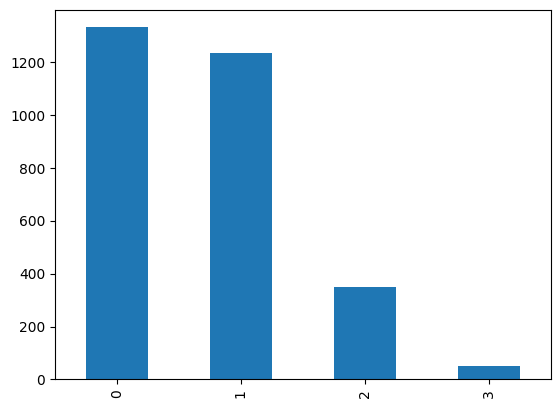

In [ ]:
engg['Internships'].value_counts().plot(kind='bar')

<Axes: >

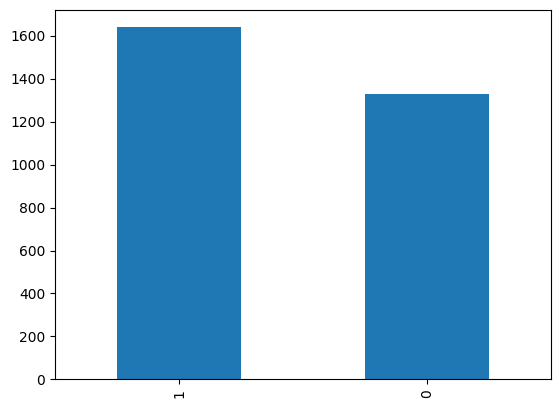

In [ ]:
engg['PlacedOrNot'].value_counts().plot(kind='bar')

<ipython-input-11-7b902717a840>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = engg.corr()


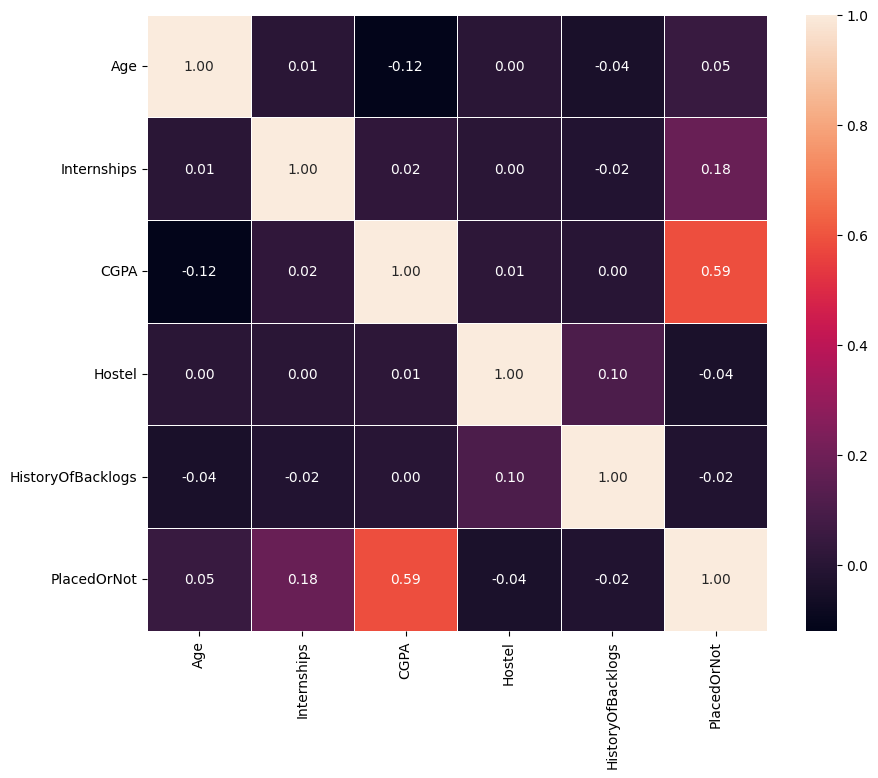

In [ ]:
corr_matrix = engg.corr()
fig , ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f')

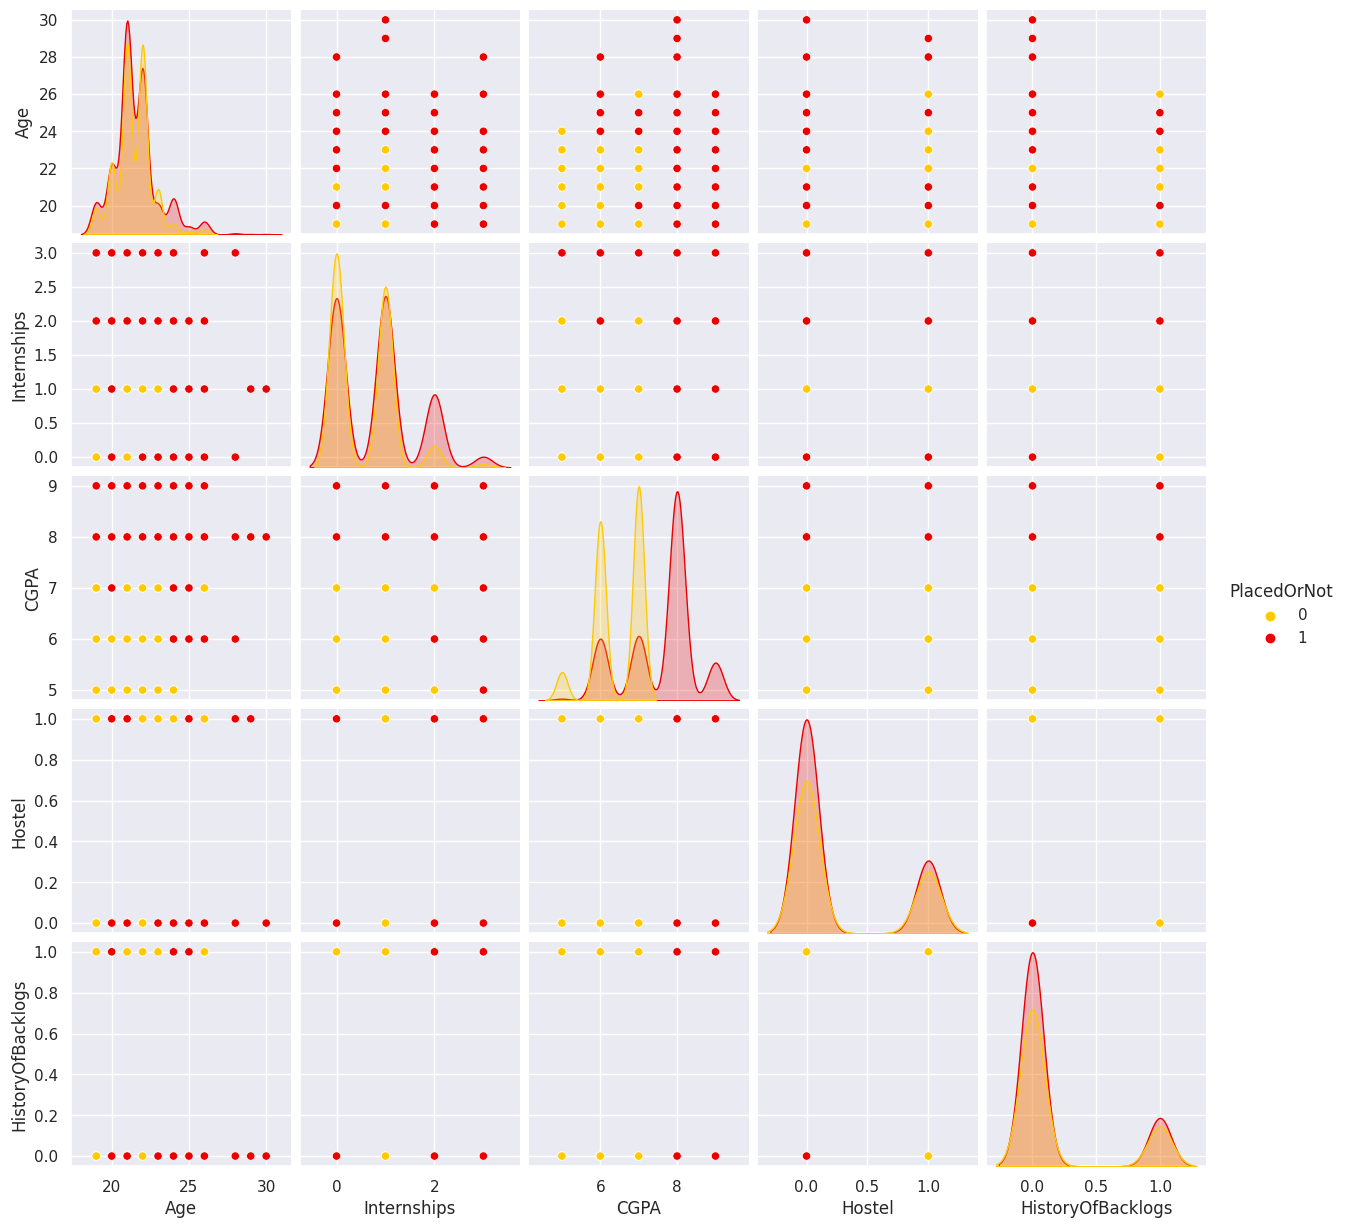

In [ ]:
sns.set_style("darkgrid")
sns.set('notebook')
sns.pairplot(engg, hue="PlacedOrNot", palette='hot_r')
plt.show()

In [ ]:
def One_Hot(dfs,columns,drop_cols):
  encoder = OneHotEncoder(handle_unknown='ignore')

  encoder_df = pd.DataFrame(encoder.fit_transform(dfs[[columns]]).toarray())
  encoder_len = len(encoder_df.columns)

  dfs = dfs.join(encoder_df)

  dfs.drop(columns, axis=1, inplace=True)

  return dfs,encoder_len

In [ ]:
def col_trans(dfs,drop_cols,encoder_len):
  cols = list(dfs.columns)
  for i in range(0,encoder_len):
    cols.remove(i)
  dfs.columns = cols+drop_cols
  return dfs

In [ ]:
cols=[]
for i in engg.columns:
    if engg[f'{i}'].dtype == 'O':
      cols.append(i)


In [ ]:
engg_copy = copy.deepcopy(engg)

In [ ]:
for i in cols:
  par_cols = list(engg[i].unique())
  engg_copy,len_enc=One_Hot(engg_copy,i,par_cols)
  engg_copy= col_trans(engg_copy,par_cols,len_enc)

In [ ]:
engg_copy

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot,Male,Female,Electronics And Communication,Computer Science,Information Technology,Mechanical,Electrical,Civil
0,22,1,8,1,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,21,0,7,1,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,22,1,6,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,21,0,8,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,22,0,8,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,23,0,7,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2962,23,1,7,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2963,22,1,7,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2964,22,1,7,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


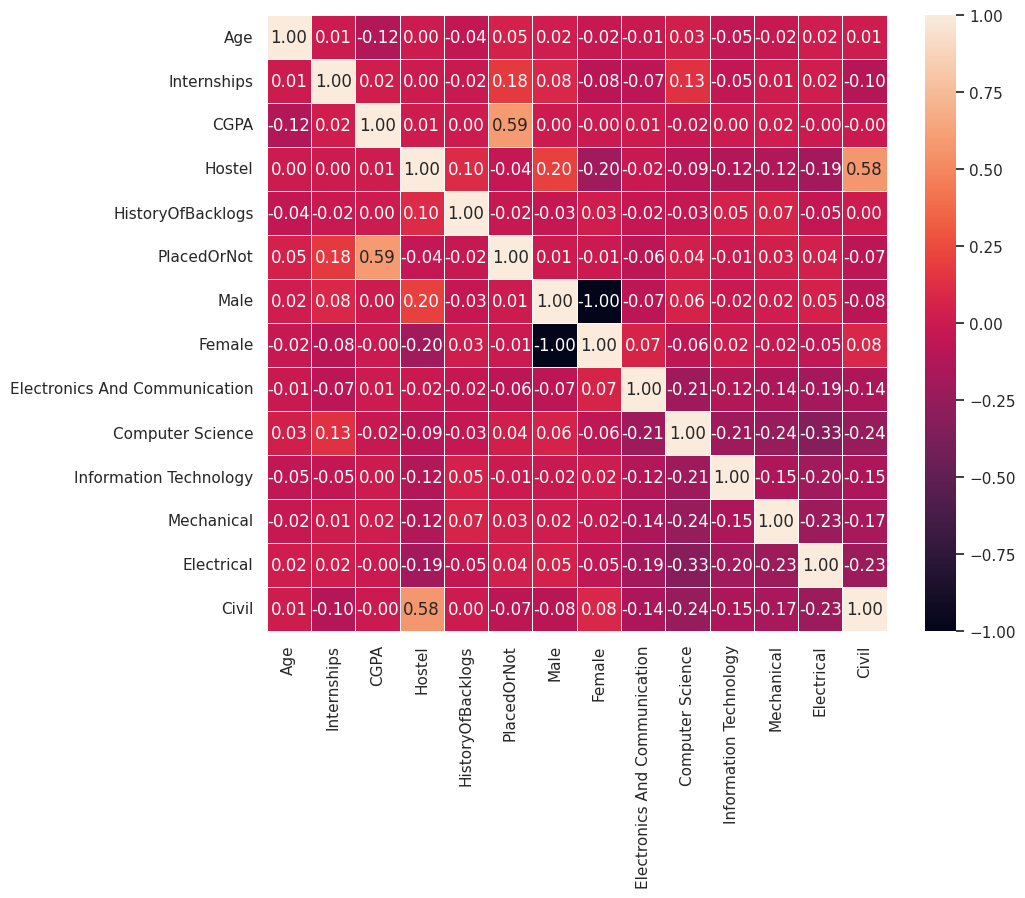

In [ ]:
corr_matrix = engg_copy.corr()
fig , ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f')

<Axes: title={'center': 'Correlation with Placement'}>

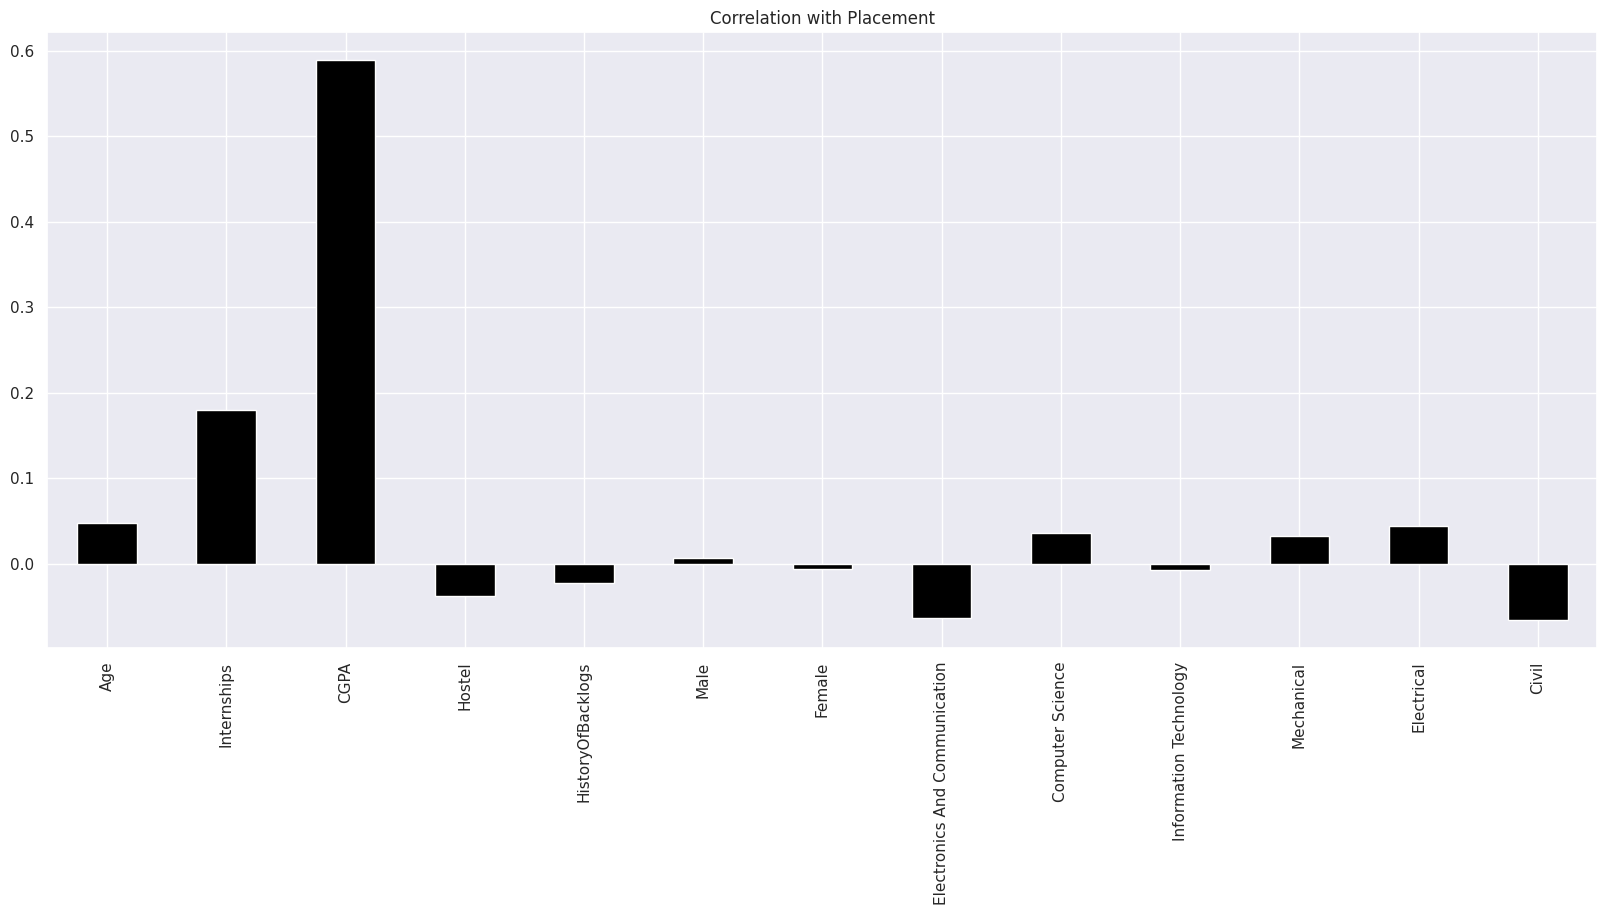

In [ ]:
engg_copy.drop('PlacedOrNot', axis=1).corrwith(engg_copy['PlacedOrNot']).plot(kind='bar', grid=True, figsize=(20, 8), title="Correlation with Placement",color="Black")

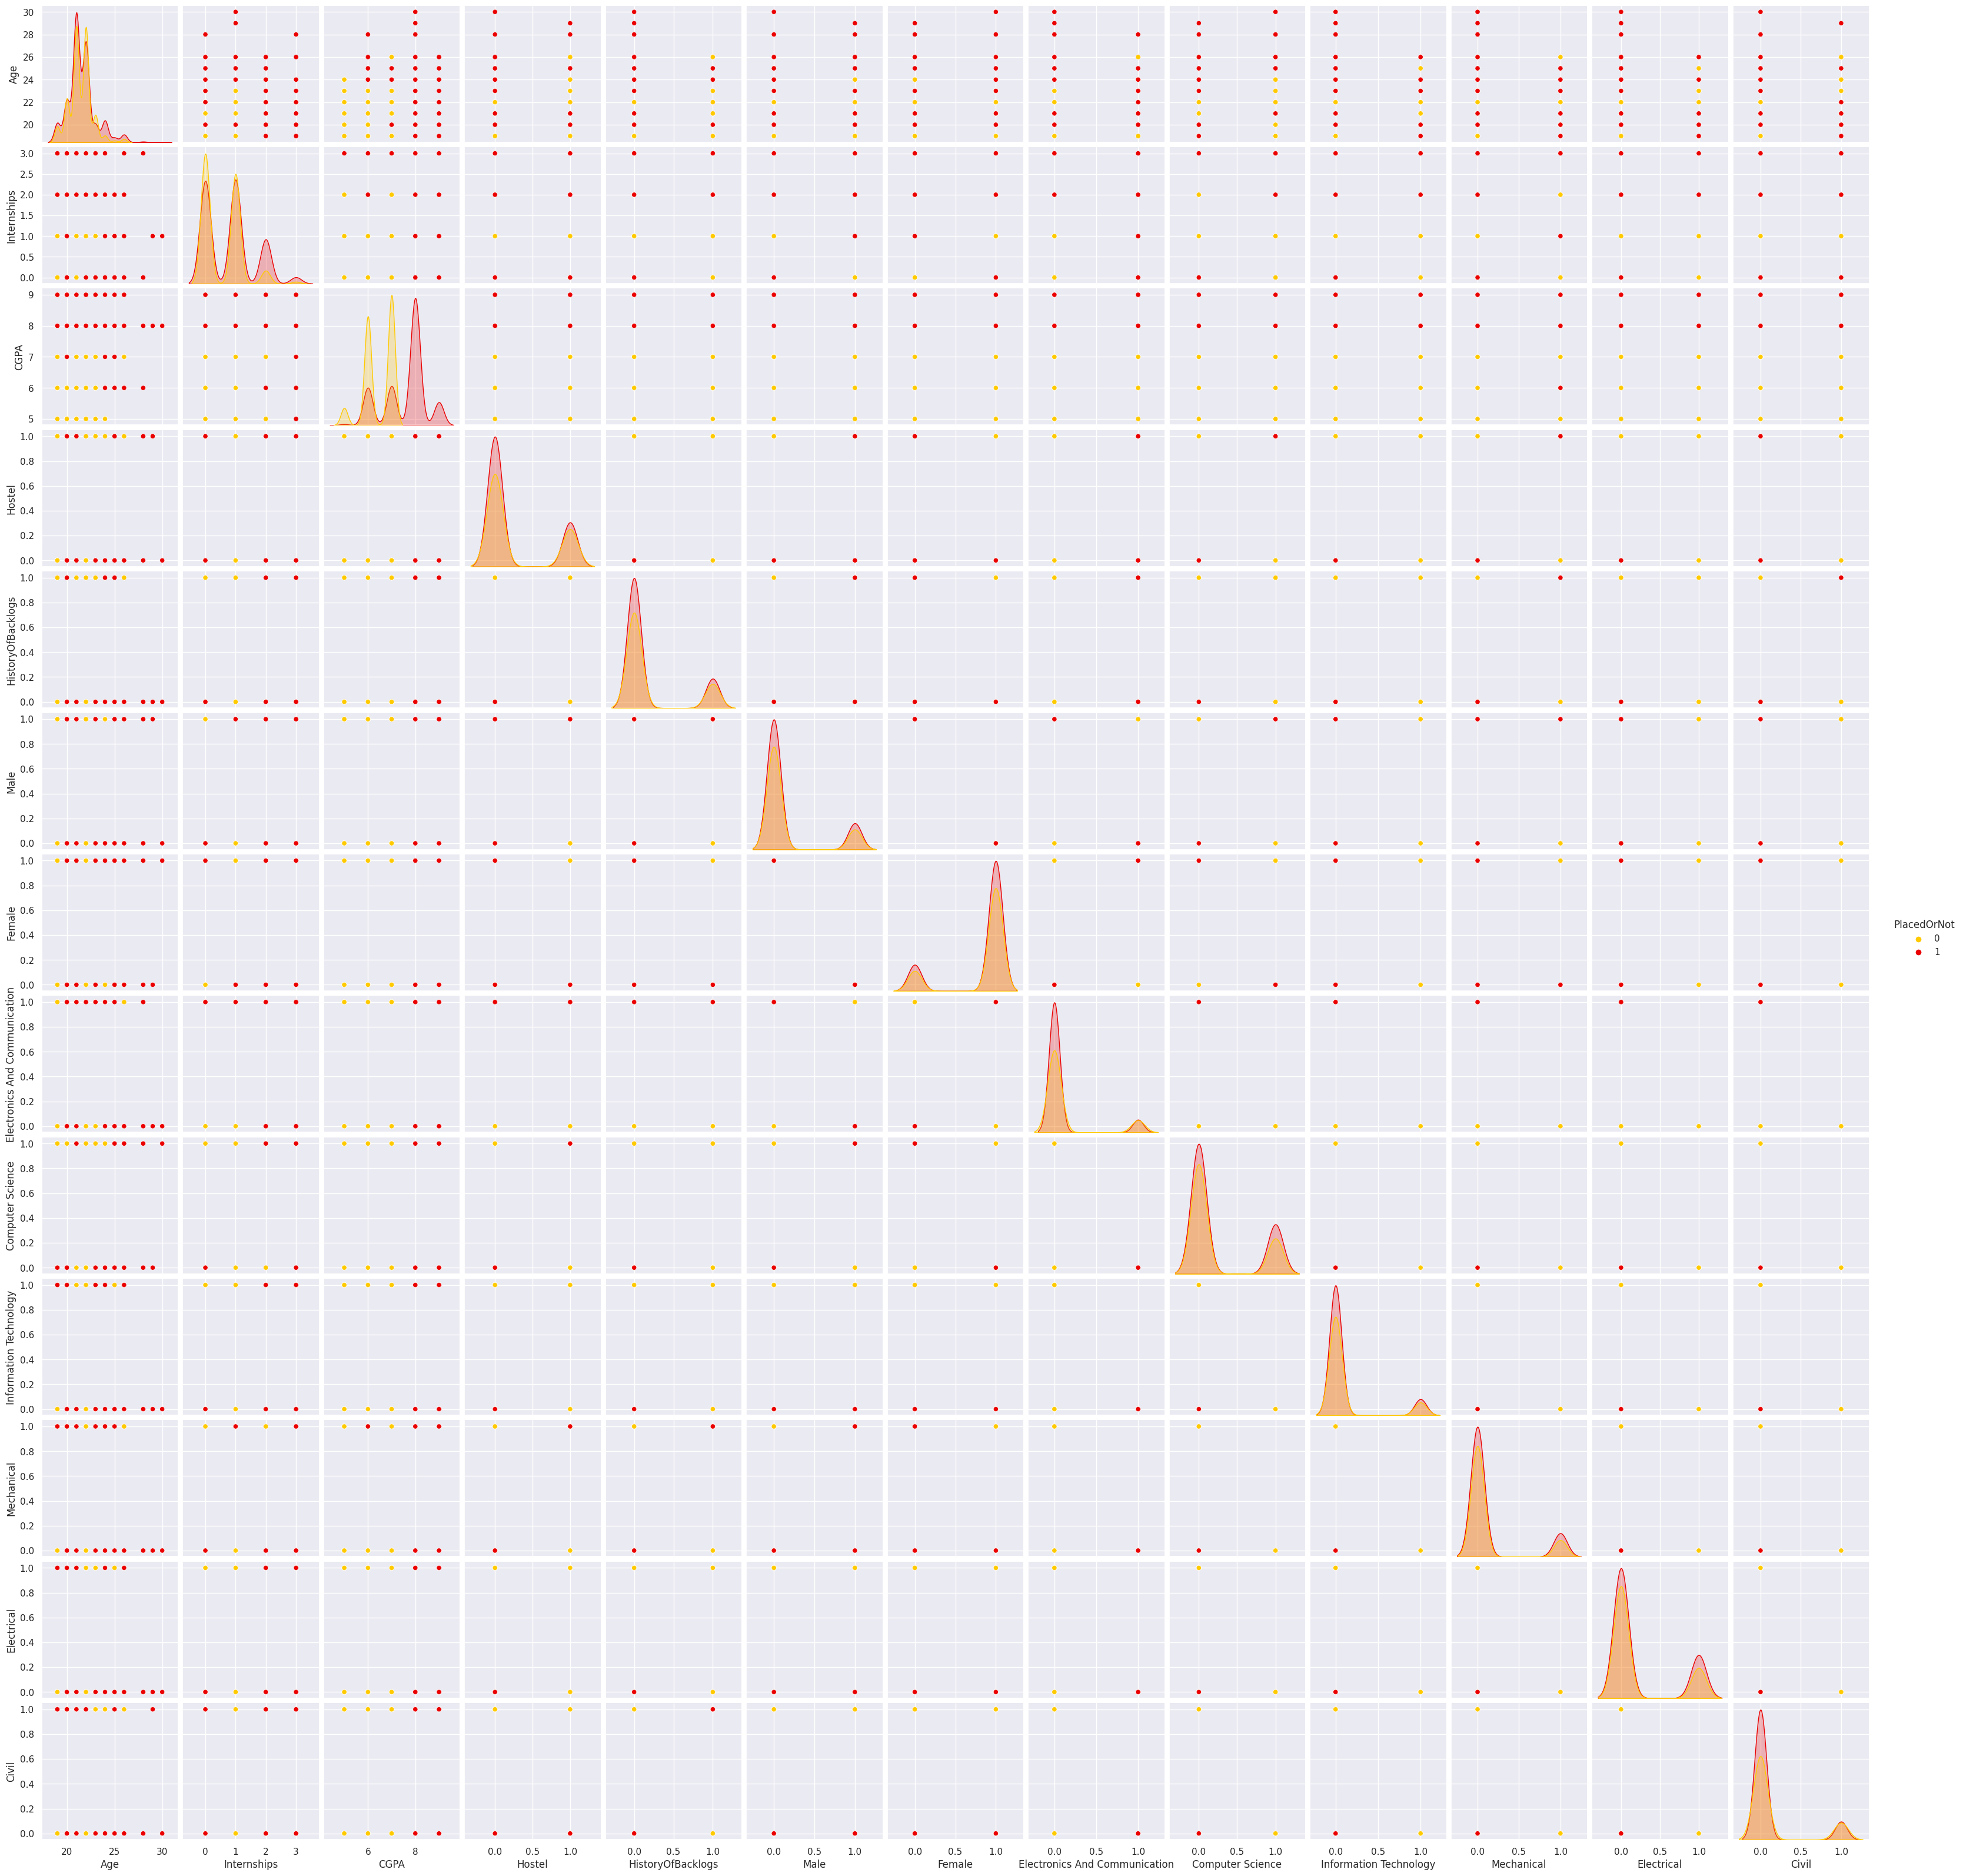

In [ ]:
sns.set_style("darkgrid")
sns.set('notebook')
sns.pairplot(engg_copy, hue="PlacedOrNot", palette='hot_r')
plt.show()

In [ ]:
num_cols = []

for i in engg.columns:
    if engg[f'{i}'].dtype == 'float64':
      num_cols.append(i)

In [ ]:
Scaler = MinMaxScaler()

for i in num_cols:
  engg_copy[i] = Scaler.fit_transform(np.array(engg_copy[i]).reshape(-1,1))

<Axes: title={'center': 'Correlation with Placement'}>

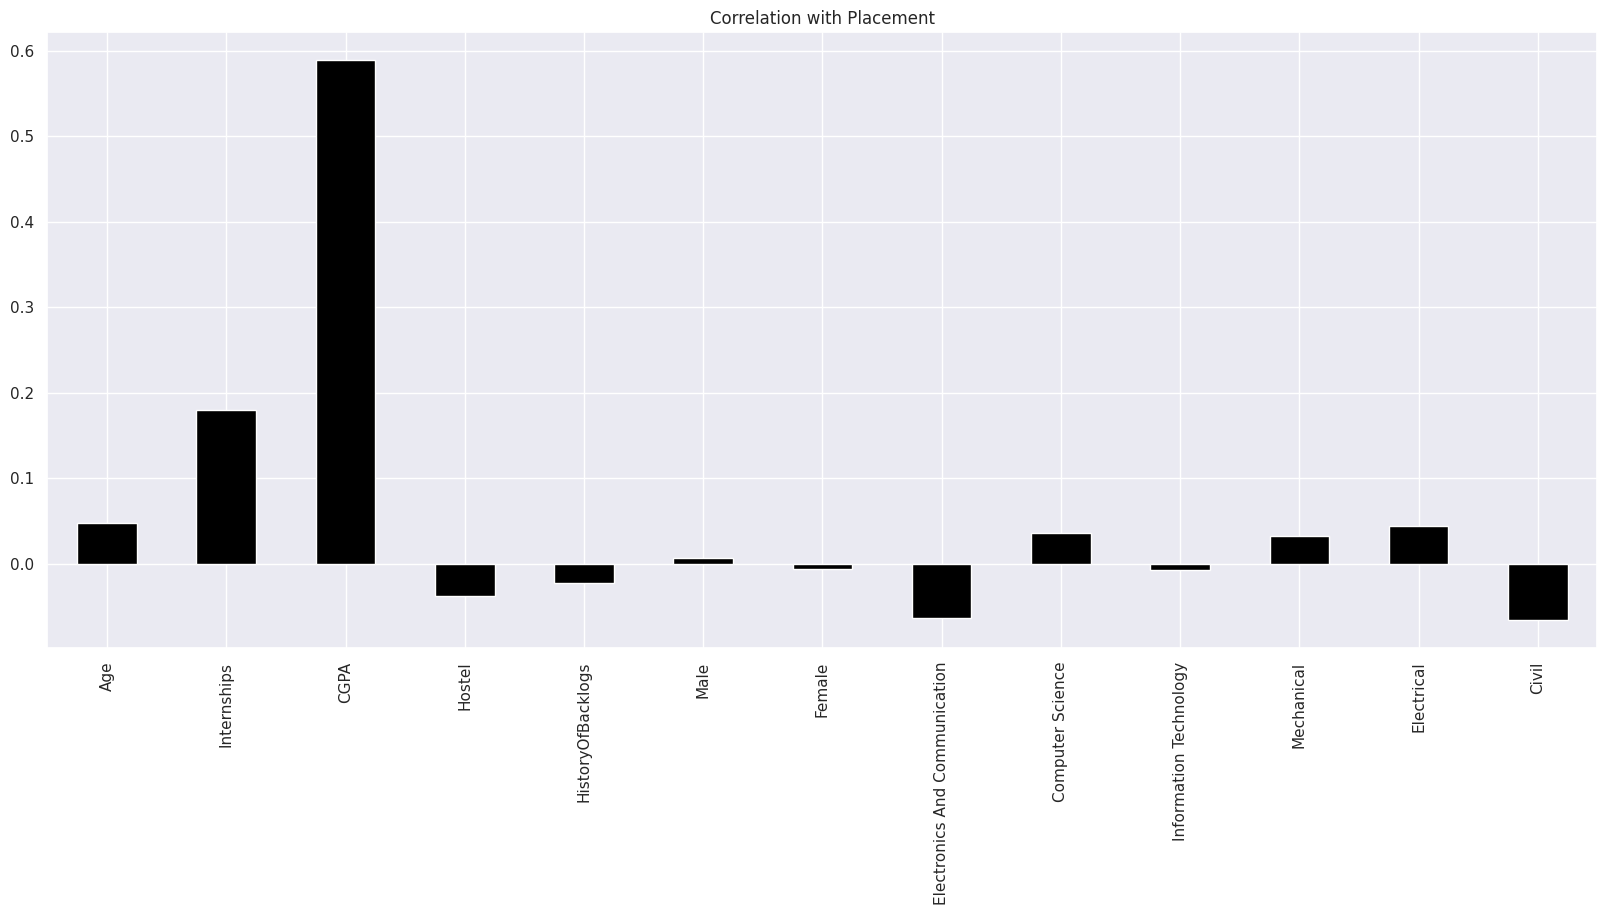

In [ ]:
engg_copy.drop('PlacedOrNot', axis=1).corrwith(engg_copy['PlacedOrNot']).plot(kind='bar', grid=True, figsize=(20, 8), title="Correlation with Placement",color="Black")

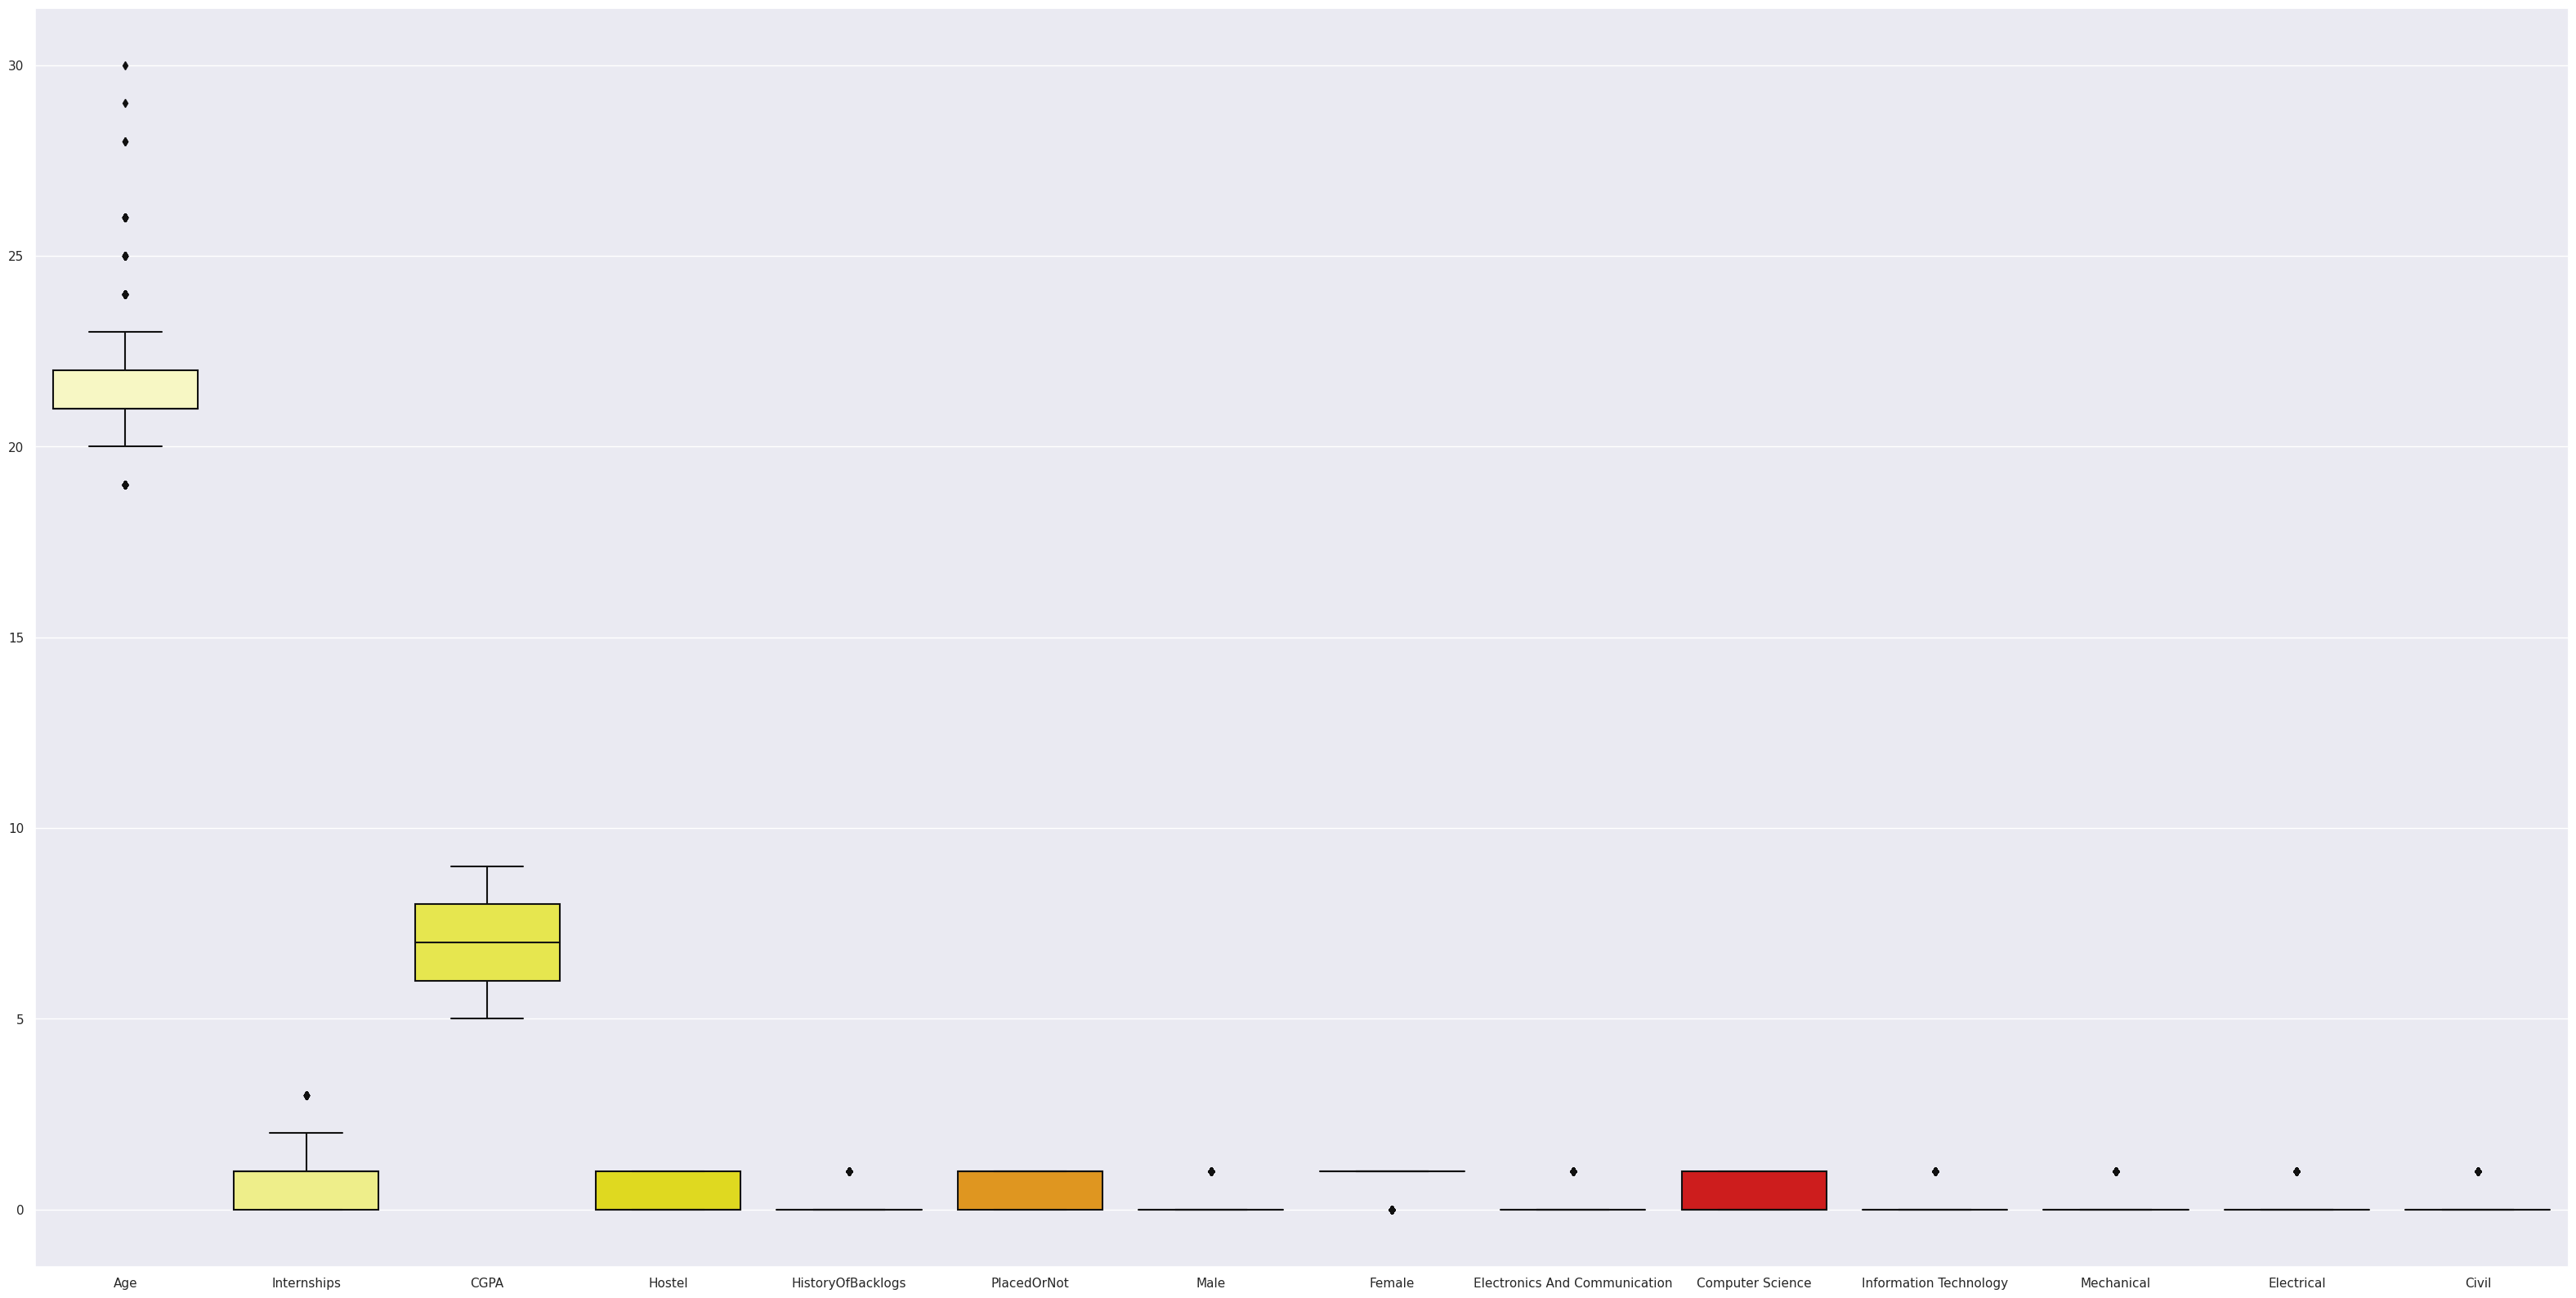

In [ ]:
fig, ax = plt.subplots(figsize=(40,20))

sns.set_style("darkgrid")
sns.set('notebook')
sns.boxplot(engg_copy, palette='hot_r')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


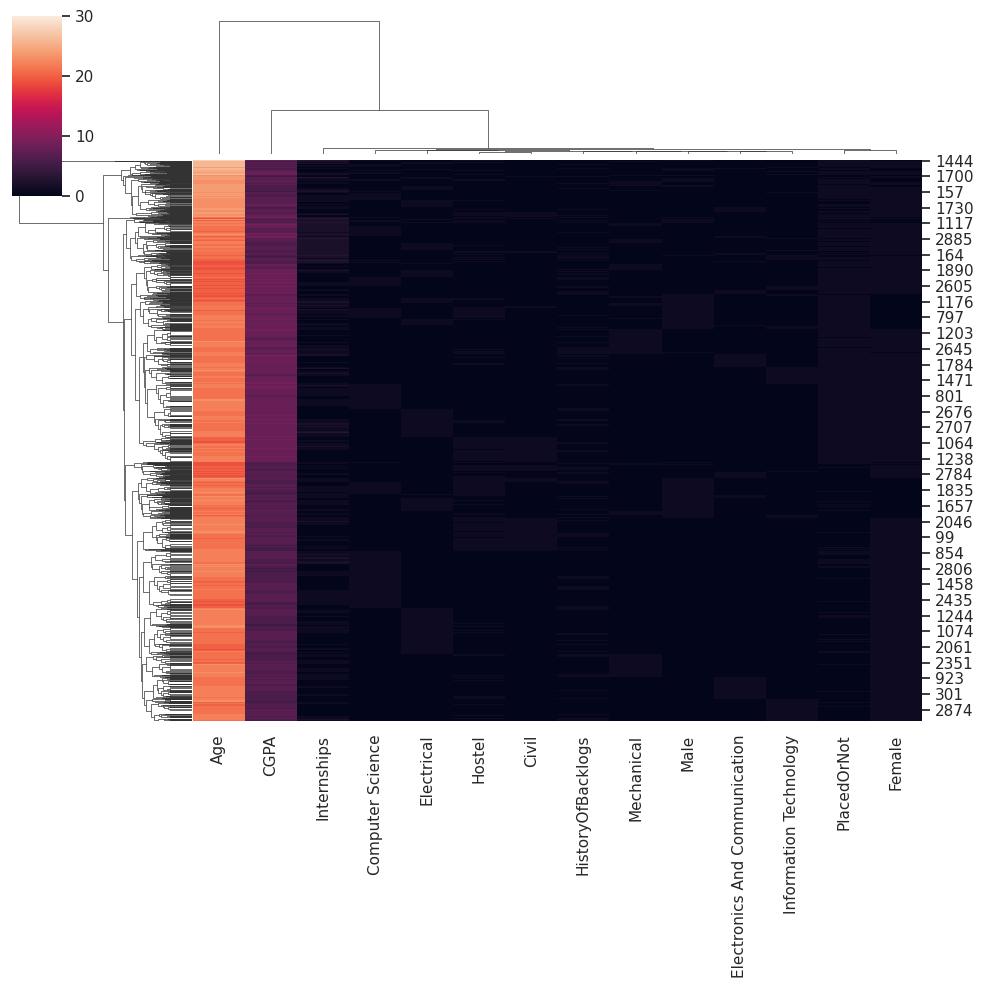

In [ ]:
sns.clustermap(engg_copy)

In [ ]:
engg

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1
3,21,Male,Information Technology,0,8,0,1,1
4,22,Male,Mechanical,0,8,1,0,1
...,...,...,...,...,...,...,...,...
2961,23,Male,Information Technology,0,7,0,0,0
2962,23,Male,Mechanical,1,7,1,0,0
2963,22,Male,Information Technology,1,7,0,0,0
2964,22,Male,Computer Science,1,7,0,0,0


In [ ]:
engg_copy1=copy.deepcopy(engg)
engg_copy1=engg_copy1.drop('Gender',axis=1)
engg_copy1=engg_copy1.drop('Stream',axis=1)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


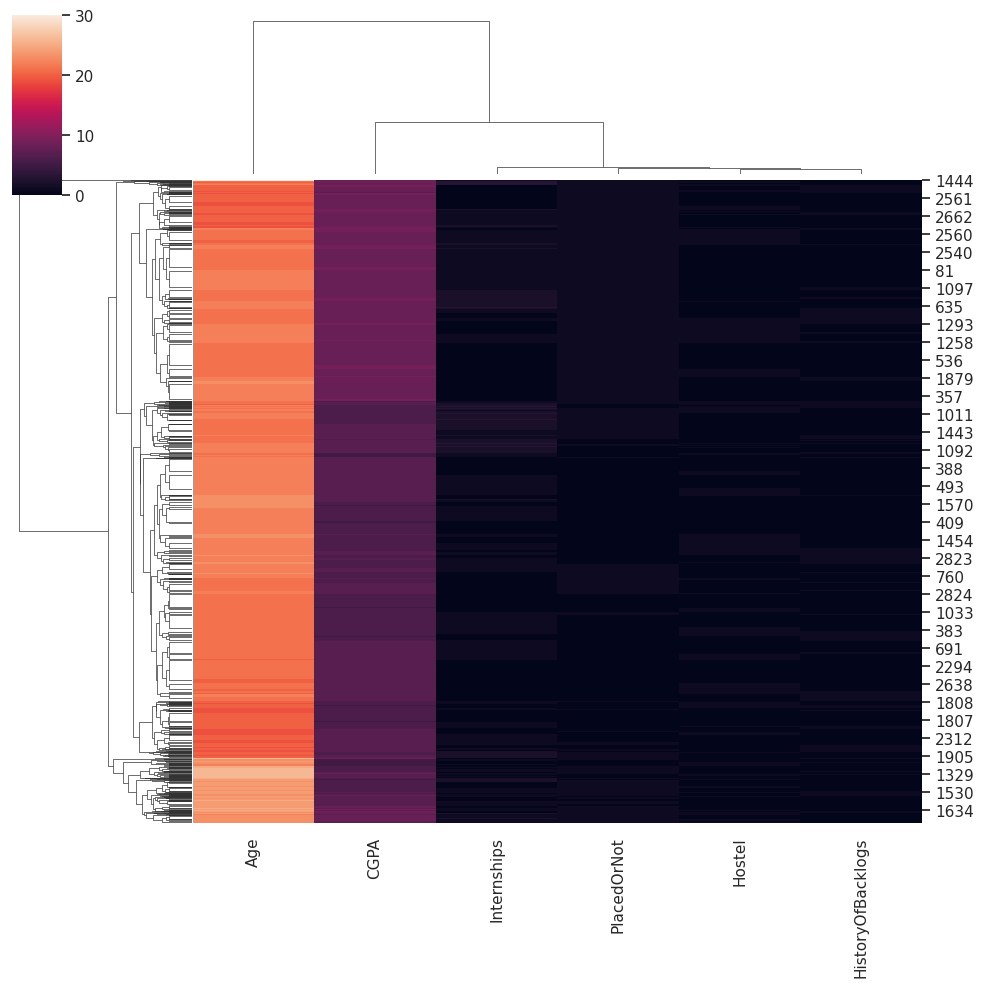

In [ ]:
sns.clustermap(engg_copy1)

In [ ]:
engg

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1
3,21,Male,Information Technology,0,8,0,1,1
4,22,Male,Mechanical,0,8,1,0,1
...,...,...,...,...,...,...,...,...
2961,23,Male,Information Technology,0,7,0,0,0
2962,23,Male,Mechanical,1,7,1,0,0
2963,22,Male,Information Technology,1,7,0,0,0
2964,22,Male,Computer Science,1,7,0,0,0


In [ ]:
X = engg[['Internships','CGPA']]
X = X.iloc[:,[0,1]].values
Y = engg[['CGPA','HistoryOfBacklogs']]
Y = Y.iloc[:,[0,1]].values
Z = engg[['Internships','HistoryOfBacklogs']]
Z = Z.iloc[:,[0,1]].values
K = engg[['CGPA','Hostel']]
K = K.iloc[:,[0,1]].values
N = engg[['Age','HistoryOfBacklogs']]
N = N.iloc[:,[0,1]].values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

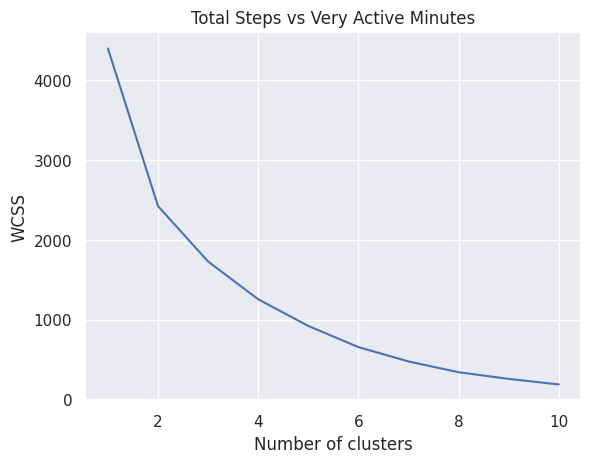

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Total Steps vs Very Active Minutes')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


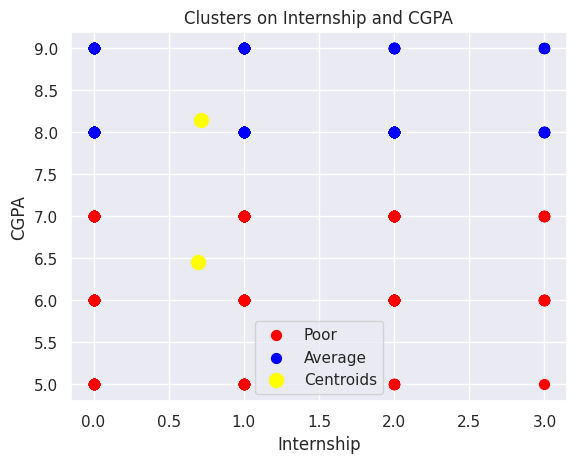

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans1 = kmeans.fit_predict(X)

plt.scatter(X[y_kmeans1 == 0, 0], X[y_kmeans1 == 0, 1], s = 50, c = 'red', label = 'Poor')
plt.scatter(X[y_kmeans1 == 1, 0], X[y_kmeans1 == 1, 1], s = 50, c = 'blue', label = 'Average')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters on Internship and CGPA')
plt.xlabel('Internship')
plt.ylabel('CGPA')
plt.legend()
plt.show()
y_kmeans1 = kmeans.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

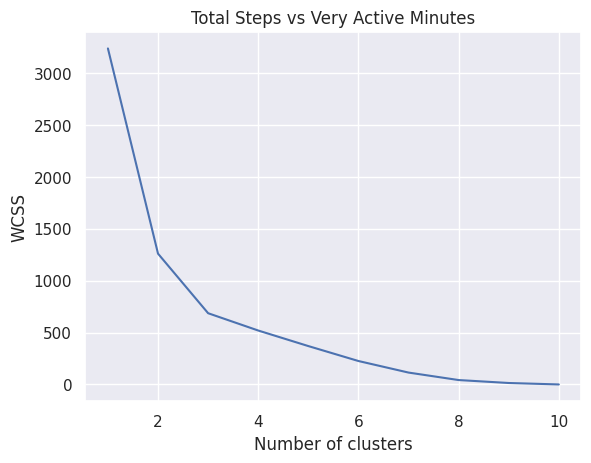

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Y)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Total Steps vs Very Active Minutes')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


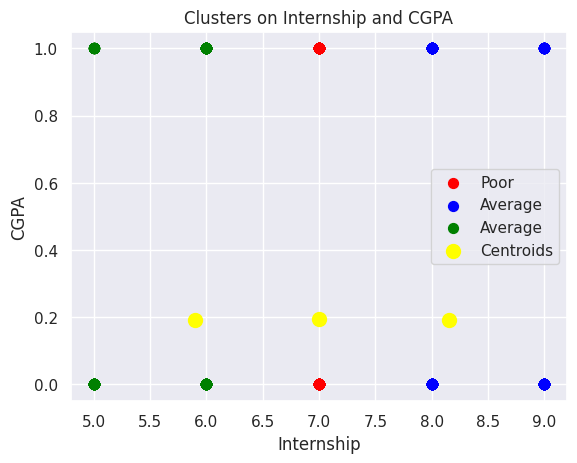

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans2 = kmeans.fit_predict(Y)

plt.scatter(Y[y_kmeans2 == 0, 0], Y[y_kmeans2 == 0, 1], s = 50, c = 'red', label = 'Poor')
plt.scatter(Y[y_kmeans2 == 1, 0], Y[y_kmeans2 == 1, 1], s = 50, c = 'blue', label = 'Average')
plt.scatter(Y[y_kmeans2 == 2, 0], Y[y_kmeans2 == 2, 1], s = 50, c = 'green', label = 'Average')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters on Internship and CGPA')
plt.xlabel('Internship')
plt.ylabel('CGPA')
plt.legend()
plt.show()
y_kmeans2 = kmeans.fit(Y)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

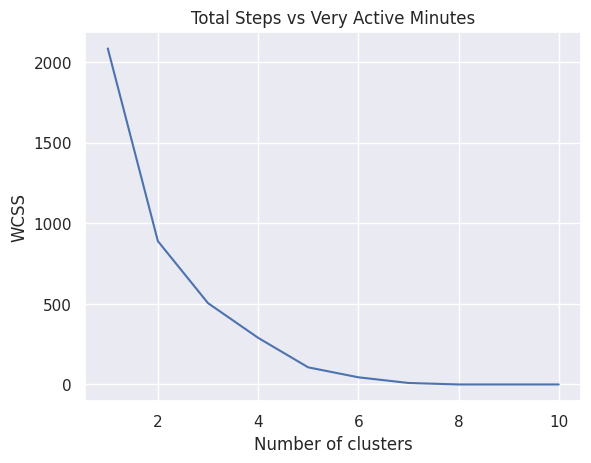

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Z)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Total Steps vs Very Active Minutes')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


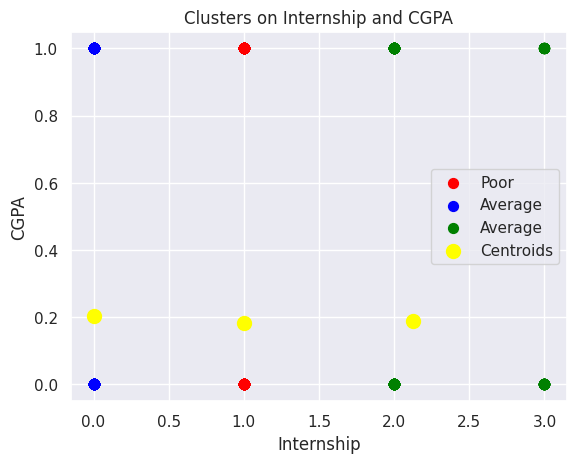

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans3 = kmeans.fit_predict(Z)

plt.scatter(Z[y_kmeans3 == 0, 0], Z[y_kmeans3 == 0, 1], s = 50, c = 'red', label = 'Poor')
plt.scatter(Z[y_kmeans3 == 1, 0], Z[y_kmeans3 == 1, 1], s = 50, c = 'blue', label = 'Average')
plt.scatter(Z[y_kmeans3 == 2, 0], Z[y_kmeans3 == 2, 1], s = 50, c = 'green', label = 'Average')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters on Internship and CGPA')
plt.xlabel('Internship')
plt.ylabel('CGPA')
plt.legend()
plt.show()
y_kmeans3 = kmeans.fit(Z)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

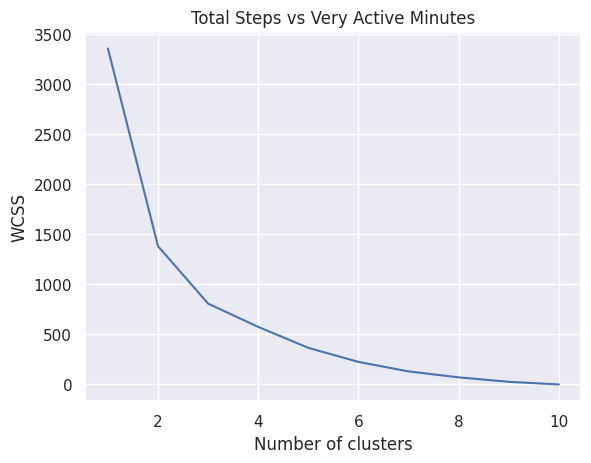

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(K)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Total Steps vs Very Active Minutes')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


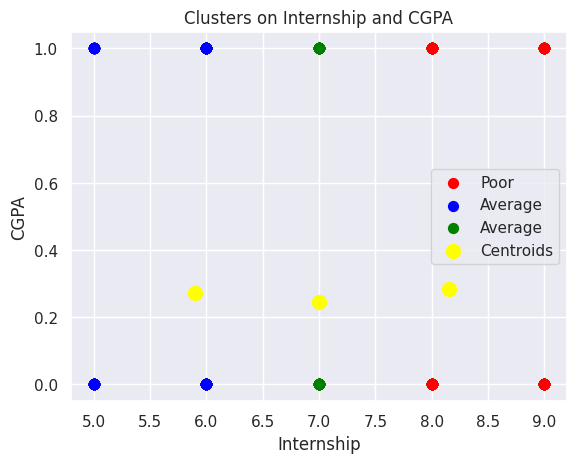

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans4 = kmeans.fit_predict(K)

plt.scatter(K[y_kmeans4 == 0, 0], K[y_kmeans4 == 0, 1], s = 50, c = 'red', label = 'Poor')
plt.scatter(K[y_kmeans4 == 1, 0], K[y_kmeans4 == 1, 1], s = 50, c = 'blue', label = 'Average')
plt.scatter(K[y_kmeans4 == 2, 0], K[y_kmeans4 == 2, 1], s = 50, c = 'green', label = 'Average')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters on Internship and CGPA')
plt.xlabel('Internship')
plt.ylabel('CGPA')
plt.legend()
plt.show()
y_kmeans4 = kmeans.fit(K)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

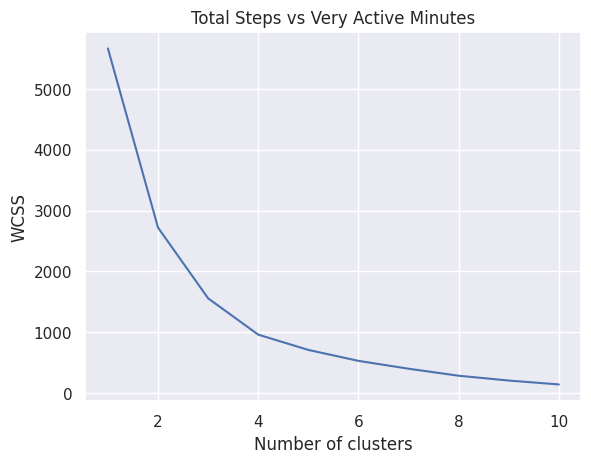

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(N)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Total Steps vs Very Active Minutes')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


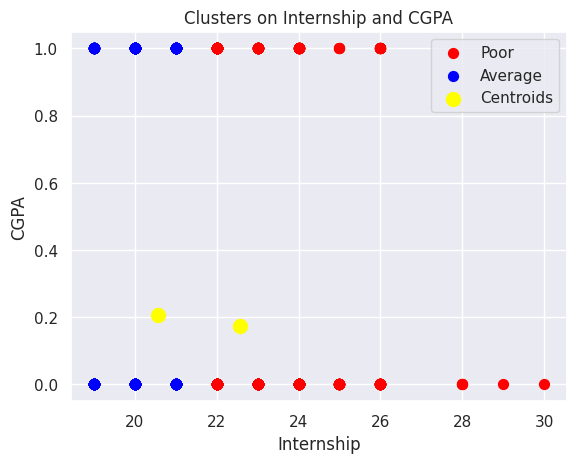

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans5 = kmeans.fit_predict(N)

plt.scatter(N[y_kmeans5 == 0, 0], N[y_kmeans5 == 0, 1], s = 50, c = 'red', label = 'Poor')
plt.scatter(N[y_kmeans5 == 1, 0], N[y_kmeans5 == 1, 1], s = 50, c = 'blue', label = 'Average')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters on Internship and CGPA')
plt.xlabel('Internship')
plt.ylabel('CGPA')
plt.legend()
plt.show()

y_kmeans5 = kmeans.fit(N)

In [ ]:
lst = [y_kmeans1,y_kmeans2,y_kmeans3,y_kmeans4,y_kmeans5]

for i in range(0,len(lst)):
  pickle.dump(lst[i], open(f'y_kmeans{i+1}_engg.pkl', 'wb'))

# Classification

In [ ]:
engg = pd.read_csv('/content/collegePlace.csv')
engg

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1
3,21,Male,Information Technology,0,8,0,1,1
4,22,Male,Mechanical,0,8,1,0,1
...,...,...,...,...,...,...,...,...
2961,23,Male,Information Technology,0,7,0,0,0
2962,23,Male,Mechanical,1,7,1,0,0
2963,22,Male,Information Technology,1,7,0,0,0
2964,22,Male,Computer Science,1,7,0,0,0


In [ ]:
def Print_values(dfs):
  for i in dfs.columns:
      print(i,":-")
      print(dfs[f'{i}'].value_counts())
      print("\n")
      print("****************************************************")

Print_values(engg)

Age :-
21    1084
22     941
20     375
23     195
19     156
24     131
26      50
25      29
28       3
30       1
29       1
Name: Age, dtype: int64


****************************************************
Gender :-
Male      2475
Female     491
Name: Gender, dtype: int64


****************************************************
Stream :-
Computer Science                 776
Information Technology           691
Electronics And Communication    424
Mechanical                       424
Electrical                       334
Civil                            317
Name: Stream, dtype: int64


****************************************************
Internships :-
0    1331
1    1234
2     350
3      51
Name: Internships, dtype: int64


****************************************************
CGPA :-
7    956
8    915
6    834
9    165
5     96
Name: CGPA, dtype: int64


****************************************************
Hostel :-
0    2168
1     798
Name: Hostel, dtype: int64


***********************

In [ ]:
X = engg.drop('PlacedOrNot',axis=1)
Y = engg['PlacedOrNot']

In [ ]:
X_train , X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

In [ ]:
Y_train.value_counts()

1    1311
0    1061
Name: PlacedOrNot, dtype: int64

In [ ]:
X

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs
0,22,Male,Electronics And Communication,1,8,1,1
1,21,Female,Computer Science,0,7,1,1
2,22,Female,Information Technology,1,6,0,0
3,21,Male,Information Technology,0,8,0,1
4,22,Male,Mechanical,0,8,1,0
...,...,...,...,...,...,...,...
2961,23,Male,Information Technology,0,7,0,0
2962,23,Male,Mechanical,1,7,1,0
2963,22,Male,Information Technology,1,7,0,0
2964,22,Male,Computer Science,1,7,0,0


In [ ]:
num_cols = []
obj_cols = []

for i in X.columns:
    if X[f'{i}'].dtype != 'O':
      num_cols.append(i)
    if X[f'{i}'].dtype == 'O':
      obj_cols.append(i)

In [ ]:
num_cols

['Age', 'Internships', 'CGPA', 'Hostel', 'HistoryOfBacklogs']

In [ ]:
Y_train.value_counts()

1    1311
0    1061
Name: PlacedOrNot, dtype: int64

In [ ]:
ct_engg = make_column_transformer(
    (MinMaxScaler(),num_cols),
    (OneHotEncoder(handle_unknown='ignore'),obj_cols))

In [ ]:
ct_engg.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['Age', 'Internships', 'CGPA', 'Hostel',
                                  'HistoryOfBacklogs']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Stream'])])

In [ ]:
pickle.dump(ct_engg,open('ct_engg.pkl','wb'))

In [ ]:
X_train = ct_engg.transform(X_train)
X_test = ct_engg.transform(X_test)

In [ ]:
# param_grid = {
#     'max_depth': range (2, 100, 20),
#     'n_estimators': range(60, 300, 60),
#     "gamma": [0, 0.5, 1],
#     "reg_lambda": [0,5,10],
#     "scale_pos_weight": range(1,10,2),
#     "subsample": [0.1,0.4,0.8],
#     "colsample_bytree": [0.1,0.5,0.8],
# }

# # Init classifier
# xgb_cl = xgb.XGBClassifier(subsample= 0.8,
#  scale_pos_weight= 5,
#  reg_lambda= 1,
#  max_depth= 5,
#  learning_rate= 0.01,
#  gamma= 1,
#  colsample_bytree= 0.5)

# # Init Grid Search
# grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="accuracy",verbose=2)

# # Fit
# grid_cv.fit(X_train, Y_train)

In [ ]:
# grid_cv.best_params_

In [ ]:
xgb_cl = xgb.XGBClassifier(subsample= 0.1,
 scale_pos_weight= 1,
 reg_lambda= 0,
 max_depth= 22,
 learning_rate= 0.01,
 gamma= 0,
 colsample_bytree= 0.5,
 n_estimators=180)

xgb_cl.fit(X_train,Y_train)

In [ ]:
Y_preds = xgb_cl.predict(X_test)
accuracy_score(Y_test,Y_preds)

In [ ]:
print(classification_report(Y_test,Y_preds))

In [ ]:
Y_train_pred = xgb_cl.predict(X_train)
accuracy_score(Y_train,Y_train_pred)

In [ ]:
lr=LogisticRegression()
lr.fit(X_train,Y_train)

In [ ]:
Y_preds = lr.predict(X_test)
accuracy_score(Y_test,Y_preds)

In [ ]:
X_train

In [ ]:
import tensorflow as tf
# Set Random seed
tf.random.set_seed(42)
Y_train = tf.constant(Y_train)
#1. Create the Model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5,activation='relu'),
    tf.keras.layers.Dense(5,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

#2. Compile the Model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr  = 0.001),
                metrics=['accuracy'])

#3. Fit the Model
history = model_1.fit(X_train,Y_train,epochs=100)

In [ ]:
import tensorflow as tf
# Set Random seed
tf.random.set_seed(42)
Y_train = tf.constant(Y_train)
#1. Create the Model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(100,activation='tanh'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(5,activation='relu'),
    tf.keras.layers.Dense(5,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

#2. Compile the Model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr  = 0.001),
                metrics=['accuracy'])

#3. Fit the Model
history = model_2.fit(X_train,Y_train,epochs=100)

In [ ]:
import tensorflow as tf
# Set Random seed
tf.random.set_seed(42)
Y_train = tf.constant(Y_train)
#1. Create the Model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(100,activation='tanh'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(50,activation='tanh'),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(5,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

#2. Compile the Model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr  = 0.001),
                metrics=['accuracy'])

#3. Fit the Model
history = model_2.fit(X_train,Y_train,epochs=100)

In [ ]:
model_2.save('engg.h5')